In [3]:
##########
#importing standard modules
import math
import os
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
import subprocess as sub
import shutil
import sys
import scipy as sci
import scipy.io as sio
from scipy.stats.stats import pearsonr
%matplotlib inline
from scipy.sparse import csr_matrix, rand
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
from matplotlib.pyplot import register_cmap,get_cmap,colorbar
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
####################       IMPORT PM's MODULES     ######################################
from plottingPM import get_colors,grayify_cmap,make_colormap,customcolorpalette
from drawmapsection3D import get_distaz,delazgc_helper,writejson,readjson, \
    plot_hotspots,plot_plates,plot_gcpaths,get_fullpath,sanitised_input,uniquenumpyrow


####################################################


In [4]:
def Get_Orig_Model(ModelFile,Depth_Interest): 
    """Extracts original model from the .mat modelfile. Does this a slightly different way than for cubed faces,
    since there are no basis functions involved here. 
    """
    ##Note that the ModelFile here has to follow the conventions as is imported from the .mat file 
    ##when generated from running the DVmatfile script in wavelets_matlab
    Vvals = ModelFile['model']
    Depth_Checker = np.nonzero(ModelFile['depth'] == (Depth_Interest))
    DvDepthVals = Vvals[0,Depth_Checker]
    ##orig. formulation above

    Depth_Checker = np.nonzero(ModelFile['depth'] == (Depth_Interest))
    DvDepthVals = Vvals[0,Depth_Checker]
    Face1Map = DvDepthVals[0,0:len(DvDepthVals[0])/6]
    Face2Map = DvDepthVals[0,len(DvDepthVals[0])/6:2*len(DvDepthVals[0])/6]
    Face3Map = DvDepthVals[0,2*len(DvDepthVals[0])/6:3*len(DvDepthVals[0])/6]
    Face4Map = DvDepthVals[0,3*len(DvDepthVals[0])/6:4*len(DvDepthVals[0])/6]
    Face5Map = DvDepthVals[0,4*len(DvDepthVals[0])/6:5*len(DvDepthVals[0])/6]
    Face6Map = DvDepthVals[0,5*len(DvDepthVals[0])/6:6*len(DvDepthVals[0])/6]
    All_map = [Face1Map,Face2Map,Face3Map,Face4Map,Face5Map,Face6Map]
    
    return All_map

def Get_RMS(ModelVals):
    """Quick elegant algorithm from stackexchange that gets rms of a vector. 
    """
    import numpy as np
    rms = np.sqrt(np.mean((abs(ModelVals))**2 )) 
    return rms
    
def Get_Scale_Indices(Scale_Interest,GridName,Database_Path):
    """Simple search to get the indices corresponding to a specific scale. 
    """
    import numpy as np
    Grids = sio.loadmat(Database_Path + GridName)
    ##Find the indices on a single face 
    ##that correspond to a particular scale or set of scales. Best used with basis wavelet maps
    for i in range(np.size(Scale_Interest)):
            Temp_Scale_Checker = np.nonzero(Grids['ScaleIndex'][0,:] == (Scale_Interest[i]))
            if i == 0:
                Scale_Checker = Temp_Scale_Checker
            elif i > 0:
                Scale_Checker = np.concatenate([Scale_Checker,Temp_Scale_Checker],axis=1)
    return(Scale_Checker)
                
def Get_Depth_Wavelet_Coeffs(ModelFile,Depth_Interest): 
    """Simple search to get wavelet coefficients at a specified depth by using indexing given in the .mat file for the model.
    """
    wvcoeffs = ModelFile['wvcoeffs']
    Depth_Checker = np.nonzero(ModelFile['depth'] == (Depth_Interest))
    Wavelet_CoeffsForADepth = wvcoeffs[0,Depth_Checker]
    Wavelet_CoeffsForADepth = Wavelet_CoeffsForADepth[0]
    return(Wavelet_CoeffsForADepth)
    
    
def Construct_Face_Map_From_WaveletCoeffs(wvcoeffs,GridName,Modelfile,Depth_Interest,Scale_Interest,Database_Path,ModelBasisName,N):
    """ This essentially runs the inverse wavelet transform but for all coefficients at a time. 
    This will probably be rendered useless in the future, but for now it iterates through all coefficients, multiplies them by the 
    corresponding basis function in the sparse map array, and then adds this to the full map. Does this separately for six faces by 
    checking if it belongs to the right face first!
    """
    NumVals = int(6)*int(2)**(int(2)*int(N))
    WaveletBasis = sio.loadmat(Database_Path + ModelBasisName)
    Grids = sio.loadmat(Database_Path + GridName)
    Depth_Coeffs = Get_Depth_Wavelet_Coeffs(Modelfile,Depth_Interest)
    Scale_Checker = Get_Scale_Indices(Scale_Interest,GridName,Database_Path)
    
    Face1Map = 0;
    Face2Map = 0;
    Face3Map = 0;
    Face4Map = 0;
    Face5Map = 0;
    Face6Map = 0;
    
    for i in range(len(Scale_Checker[0])):
        Curr_Index = Scale_Checker[0][i] 
        Curr_BasisIndex = Curr_Index%(NumVals/6)

                            #    Curr_Coeff = Depth_100_Coeffs[Curr_Index]
        Curr_Coeff = Depth_Coeffs[Curr_Index]
        if Grids['face'][Curr_Index] == 1:
            Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
            Face1Map = Face1Map+Curr_Map*Curr_Coeff
        elif Grids['face'][Curr_Index] == 2:
            Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
            Face2Map = Face2Map+Curr_Map*Curr_Coeff
        elif Grids['face'][Curr_Index] == 3:
            Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
            Face3Map = Face3Map+Curr_Map*Curr_Coeff
        elif Grids['face'][Curr_Index] == 4:
            Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
            Face4Map = Face4Map+Curr_Map*Curr_Coeff
        elif Grids['face'][Curr_Index] == 5:
            Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
            Face5Map = Face5Map+Curr_Map*Curr_Coeff
        elif Grids['face'][Curr_Index] == 6:
            Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
            Face6Map = Face6Map+Curr_Map*Curr_Coeff

    All_map =[(np.transpose(Face1Map)).flatten(),(np.transpose(Face2Map)).flatten(),(np.transpose(Face3Map)).flatten(),(np.transpose(Face4Map)).flatten(),(np.transpose(Face5Map)).flatten(),(np.transpose(Face6Map)).flatten()]
    return(All_map)

def RMS_of_Cubed_Sphere(All_map):
    """Calls an earlier RMS routine to get RMS across 6 faces on the cubed sphere after concatenating 
    and flattening data on all the faces. 
    """
    for i in range(len(All_map)):
        if i == 0:
            value = All_map[i]
            value = np.transpose(value)
            Fullvalue = value.flatten()
        elif i > 0:
            value = All_map[i]
            value = np.transpose(value)
            value = value.flatten()
            Fullvalue = np.concatenate([Fullvalue,value],axis=0)
    return(Get_RMS(Fullvalue))

def Plot_Map (All_map,ax,input_title,WaveletBasis,Grids,colormaxinput):
    """ Plots a robinson projection map of data in the inverse of the wavelet domain. 
    Assumes you've imported basemap and stuff. Also note that it plots by iterating over cubed faces,
    so your input data should be in the format [face1 face2 face3 face4 face5 face6]
    """
    Nbasis = len(WaveletBasis['Me'][0,:])
    for i in range(len(All_map)):
    #Plot a wavelet from a selected face
        #print(i)

        face = i
        value = All_map[i]
        value = np.transpose(value)
        value = value.flatten()

        N = Grids['MetaN'][0][0]
        ScaleIndex = Grids['ScaleIndex'][0][0]
        #print ScaleIndex
        Jmax = Grids['MetaJmax'][0][0]
        lonwav = Grids['lon'][face*Nbasis:(face+1)*Nbasis]
        latwav = Grids['lat'][face*Nbasis:(face+1)*Nbasis]


        # Define a colorscale
        #colormax=np.amax(abs(value)) #(-colormax,colormax) are the limits of the colorbar (This varies with each face, too risky right now)
        colormax= colormaxinput
        greylimit=0.001*colormax  #this is the limit to which the middle color (grey) will extend on either side of colorttmax mid
        name='r_lgrey_b'
        c = colors.ColorConverter().to_rgb
        colorlist=[c('red'), c('lightgray'), (2.*colormax-2.*greylimit)/(4.*colormax), c('lightgray'),c('lightgray'), (2.*colormax+2.*greylimit)/(4.*colormax), c('lightgray'),c('blue'), 1., c('blue')]
        custom_cmap = make_colormap(colorlist,name)
        register_cmap(name=custom_cmap.name, cmap=custom_cmap)
        palette=custom_cmap.name

        colorVal=get_colors(val=value,xmin=-colormax,xmax=colormax,palette=palette)
        #print colorVal.shape,value.shape,lonwav.shape


        # Make the figure

        m = Basemap(projection='robin', lon_0=0,resolution='c',ax=ax)
        m.drawcoastlines()
        x, y = m(lonwav,latwav); 
        cm = get_cmap(palette)
        sc = ax.scatter(x, y, c=colorVal, vmin=-colormax, vmax=colormax, edgecolor= '', cmap=cm)
        #sc = ax.scatter(x, y, c=colorVal, vmin=-2, vmax=2, edgecolor= '', cmap=cm)

        # Set title
        titlestr  = input_title
        #titlestr='N='+str(N)+', Jmax='+str(Jmax)+ ',Depth='+str(6371-Depth_Interest)+',Scales Used:'+str(Scale_Interest)#'+str(face+1),
        ax.set_title(titlestr,fontsize=12)

        # draw parallels and meridians.
        # labels = [left,right,top,bottom]
        parallels = np.arange(-60,90,30.)
        m.drawparallels(parallels,labels=[False,True,False,False])
        meridians = np.arange(0.,360.,90.)
        m.drawmeridians(meridians,labels=[False,False,False,True])
    return(ax)

def Get_Scale_Coeffs (ModelFile,Scale_Interest,GridName,Database_Path,Depth_Interest):
    """ This uses other routines to extract the exact wavelet coefficients which correspond to a 
    specific scale of interest. Assumes files have been read in in earlier blocks!     
    """
    Coeff_List = [];
    Model_ScaleIndices =  Get_Scale_Indices(ModelFile,Scale_Interest,GridName,Database_Path)
    Model_Depth_Coeffs = Get_Depth_Wavelet_Coeffs(ModelFile,Depth_Interest)
    for i in range(len(Model_ScaleIndices[0])):
        Curr_Index = Model_ScaleIndices[0][i] 
        Curr_Coeff = Model_Depth_Coeffs[Curr_Index]                
        Coeff_List.append(Curr_Coeff)


    return(Coeff_List)

In [5]:
###Compare wavelet coeffients
####SETUP

Database_Path = '/home/anant/Software/rem3d/rem3d/files/'
N = 7
Jmax = 4
WaveletBasisFn = 'D4'
eo =0
EulerConfig = 1
ModelName = 'MIT_P08'
NumVals = int(6)*int(2)**(int(2)*int(N))
Sphere_Param = 'SC'
Preconditioning = 'Precon'  #Precoff or Precon

####More Setup for File Names
##Naming Conventions

DVBasisName = Preconditioning + '_Mmaps.'+ 'N' + str(N) + '.J' + str(Jmax) + '.' + WaveletBasisFn + '.mat'
WaveletCoeffBasisName =  Preconditioning+'_WCoeffs.' + 'N'+str(N) + '.J' + str(Jmax) + '.' + \
                            WaveletBasisFn + '.mat'
GridName= Sphere_Param + '_'+'Grid_N' + str(N) + '_Jmax' + str(Jmax) + \
              '_EulerConfig' + str(EulerConfig) + '.mat'
MITVeloName = Sphere_Param + '_' + ModelName + '.N' + str(N) + '.Jmax' + str(Jmax) +  \
              '.EulerConfig' + str(EulerConfig) + '.mat'
####Read the .mat files.
WaveletBasis = sio.loadmat(Database_Path + DVBasisName)
WaveletCoeffBasis = sio.loadmat(Database_Path + WaveletCoeffBasisName)
Grids = sio.loadmat(Database_Path + GridName)
MITModelFile = sio.loadmat(Database_Path + MITVeloName)
####
#Declare some variables
MITVvals = MITModelFile['model']
MITwvcoeffs = MITModelFile['wvcoeffs']
Depths = MITModelFile['depth']
Depth_List = np.unique(Depths)
Depth_List = np.flip(Depth_List,0)

############
ModelName = 'ME16_Vp'
ME16VeloName = Sphere_Param + '_' + ModelName + '.N' + str(N) + '.Jmax' + str(Jmax) +  \
              '.EulerConfig' + str(EulerConfig) + '.mat'
####Read the .mat files.
WaveletBasis = sio.loadmat(Database_Path + DVBasisName)
WaveletCoeffBasis = sio.loadmat(Database_Path + WaveletCoeffBasisName)
Grids = sio.loadmat(Database_Path + GridName)
ME16ModelFile = sio.loadmat(Database_Path + ME16VeloName)
####
#Declare some variables
ME16Vvals = ME16ModelFile['model']
ME16wvcoeffs = ME16ModelFile['wvcoeffs']
Depths = ME16ModelFile['depth']
Depth_List = np.unique(Depths)
Depth_List = np.flip(Depth_List,0)


In [6]:
Depth_List = np.unique(Depths)
Depth_List = np.flip(Depth_List,0)
Scale_Interest = [4,5]
N = 7
x=[];y=[];z=[]
Construct_Whole_Model = 0


In [7]:
Rad_Corr_Matrix = np.zeros(shape = (    len(Depth_List)  , len(Depth_List)   )    )
x=[];y=[];z=[]
for i in range(len(Depth_List)): 
    Curr_Depth = Depth_List[i]
    if Construct_Whole_Model == 1:
        Map1 = Get_Orig_Model(ME16ModelFile,Curr_Depth)
    else:
        Map1 = Construct_Face_Map_From_WaveletCoeffs(ME16wvcoeffs,GridName,ME16ModelFile,Curr_Depth,Scale_Interest,Database_Path,DVBasisName,N)
    #flatten here.
    for ii in range(len(Map1)):
        if ii == 0:
            value = Map1[ii]
            value = np.transpose(value)
            Fullvalue = value.flatten()
        elif ii > 0:
            value = Map1[ii]
            value = np.transpose(value)
            value = value.flatten()
            Fullvalue = np.concatenate([Fullvalue,value],axis=0)
    FlatMap1 = Fullvalue
    print(Curr_Depth)
    #for j in range(i, len(Depth_List)):
    for j in range(len(Depth_List)):
        The_Other_Depth = Depth_List[j]
        if Construct_Whole_Model == 1:
            Map2 = Get_Orig_Model(MITModelFile,The_Other_Depth)
        else:   
            Map2 = Construct_Face_Map_From_WaveletCoeffs(MITwvcoeffs,GridName,MITModelFile,The_Other_Depth,Scale_Interest,Database_Path,DVBasisName,N)
            #flatten here.
        for ii in range(len(Map2)):
            if ii == 0:
                value = Map2[ii]
                value = np.transpose(value)
                Fullvalue = value.flatten()
            elif ii > 0:
                value = Map2[ii]
                value = np.transpose(value)
                value = value.flatten()
                Fullvalue = np.concatenate([Fullvalue,value],axis=0)
                    
        FlatMap2 = Fullvalue
        currcorcoeff = pearsonr(FlatMap1, FlatMap2)
        currcorcoeff2 = currcorcoeff[0]
        Rad_Corr_Matrix[i,j] = currcorcoeff2  
        print(currcorcoeff2)
        x.append(6371-Curr_Depth)
        y.append(6371-The_Other_Depth)
        z.append(currcorcoeff2)

                


6346
-0.228960421896
0.310036944652
0.301307461918
0.322987979276
0.269556756631
0.178829708596
0.13238283068
0.130926972761
0.0232895068232
-0.00206808391362
-0.0609986373899
-0.138273067872
-0.155932293798
-0.171955580106
-0.175894913268
-0.175556213724
-0.186813572784
-0.200637358881
-0.200850848555
-0.166133856965
-0.155217284269
-0.154552587577
-0.117579653028
-0.117686611344
-0.142550113541
-0.142838117447
-0.125743785547
-0.125929401436
-0.123806727929
6271
-0.641581441506
0.309022094919
0.331836791345
0.329165539682
0.304106588784
0.242050635461
0.162899731607
0.148285259039
0.0896909730667
0.0899880143334
0.0485048963768
-0.0182080668564
-0.0198440233473
-0.0241740589714
-0.0212931978657
-0.0406931415149
-0.057400713465
-0.0635097304769
-0.0633277590218
-0.0510750080078
-0.0608157668161
-0.0600769367194
-0.0162743594323
-0.0163399681182
-0.0263288286104
-0.026470483257
0.0153743624582
0.0149333921491
0.0158625973336
6171
-0.814197880478
0.196804350674
0.237014258728
0.21857157

/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


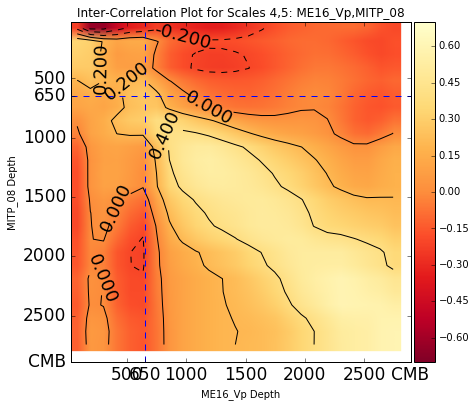

In [8]:
colmin = -0.7
colmax = 0.7
fig = plt.figure(figsize=(30,10), dpi=300, facecolor='w')

iii= 0
depthinterval=25.
deginterest=12

x=np.array(x);y=np.array(y);z=np.array(z)
    # Set up a regular grid of interpolation points
xi, yi = np.linspace(x.min(), x.max(), depthinterval), np.linspace(y.min(), y.max(), depthinterval)
xi, yi = np.meshgrid(xi, yi)

# Interpolate
rbf = sci.interpolate.Rbf(x, y, z, function='linear')
zi = rbf(xi, yi)
palette='YlOrRd_r'

levels = np.arange(-0.2,1,0.2)

ax = fig.add_subplot(1,4,iii+1)
    #im=ax.imshow(zi, vmin= round(np.min(z),1), vmax=round(np.max(z),1), origin='upper',extent=[x.min(), x.max(), y.max(), y.min()],cmap=palette)
im=ax.imshow(zi, vmin= colmin, vmax=colmax, origin='upper',extent=[x.min(), x.max(), y.max(), y.min()],cmap=palette)
contour = ax.contour(zi, vmin= colmin, vmax=colmax, origin='upper',extent=[x.min(), x.max(), y.max(), y.min()],colors='k')
ax.clabel(contour,inline=1,fontsize=18)
plt.axhline(650, 0, 2891, None, ls='dashed')
plt.axvline(650, 0, 2891, None, ls='dashed')

Depthslist = [500, 650, 1000,1500,2000,2500,2891]
y_ticks_labels = ['500','650','1000','1500','2000','2500','CMB']
x_ticks_labels = ['500','650','1000','1500','2000','2500','CMB']
ax.set_xlim(x.min(),2891)
ax.set_ylim(2891,y.min())
ax.set_title('Inter-Correlation Plot for Scales 4,5: ME16_Vp,MITP_08')
ax.set_xlabel('ME16_Vp Depth')
ax.set_ylabel('MITP_08 Depth')
        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.

        #cbar=plt.colorbar(im, cax=cax)


        # Set number of ticks for x-axis
ax.set_yticks(Depthslist)
    # Set ticks labels for x-axis
ax.set_yticklabels(y_ticks_labels, rotation='horizontal',fontsize=17)
ax.set_xticklabels(x_ticks_labels, rotation='horizontal',fontsize=17)

        # Set number of ticks for y-axis
ax.set_xticks(Depthslist)

    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="6%", pad=0.05)
        #fig.subplots_adjust(left = 5)  

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.05)
#fig.subplots_adjust(left = 5) 
cbar=plt.colorbar(im, cax=cax)   